In [1]:
import os

def mkdir(p):
    if not os.path.exists(p):
        os.mkdir(p)

def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst, target_is_directory=True)

classes = [
  'healthy',
  'stye'
]

train_path_from = os.path.abspath('../eye_test_2class/Training')
valid_path_from = os.path.abspath('../eye_test_2class/Validation')

train_path_to = os.path.abspath('../eye_test_2class/Training')
valid_path_to = os.path.abspath('../eye_test_2class/Validation')

mkdir(train_path_to)
mkdir(valid_path_to)


for c in classes:
    link(train_path_from + '/' + c, train_path_to + '/' + c)
    link(valid_path_from + '/' + c, valid_path_to + '/' + c)

In [2]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

Using TensorFlow backend.


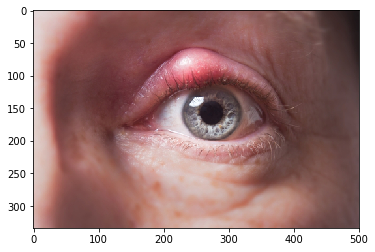

In [3]:
# re-size all the images to this
IMAGE_SIZE = [250, 250] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size=33

train_path = '../eye_test_2class/Training'
valid_path = '../eye_test_2class/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

folders = glob(train_path + '/*')

plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [4]:
len(image_files)

65

In [5]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

In [6]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
#for x, y in test_gen:
#    print("min:", x[0].min(), "max:", x[0].max())
#    plt.title(labels[np.argmax(y[0])])
#    plt.imshow(x[0])
#    plt.show()
#    break

Found 20 images belonging to 2 classes.
{'healthy': 0, 'stye': 1}


In [12]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)



Found 65 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/5
1/1 [==============================] - 20s 20s/step - loss: 4.4380 - acc: 0.6562 - val_loss: 4.5572 - val_acc: 0.7000
Epoch 2/5
1/1 [==============================] - 19s 19s/step - loss: 2.1023 - acc: 0.8182 - val_loss: 3.6988 - val_acc: 0.7500
Epoch 3/5
1/1 [==============================] - 19s 19s/step - loss: 2.1273 - acc: 0.8125 - val_loss: 3.5973 - val_acc: 0.7000
Epoch 4/5
1/1 [==============================] - 20s 20s/step - loss: 1.3953 - acc: 0.8788 - val_loss: 3.7929 - val_acc: 0.7500
Epoch 5/5
1/1 [==============================] - 19s 19s/step - loss: 0.9764 - acc: 0.9062 - val_loss: 2.4223 - val_acc: 0.8500


In [13]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 65
Found 65 images belonging to 2 classes.
[[25  7]
 [ 1 32]]


In [14]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 20
Found 20 images belonging to 2 classes.
[[8 2]
 [1 9]]


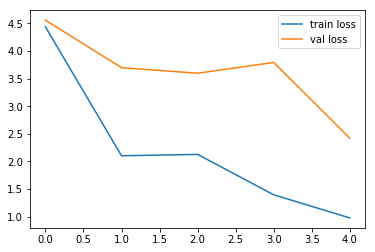

In [15]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

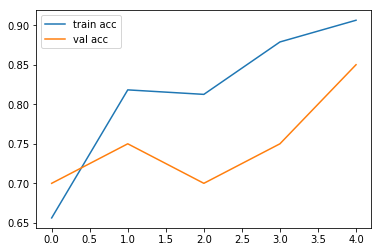

In [16]:
# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

Confusion matrix, without normalization
[[25  7]
 [ 1 32]]


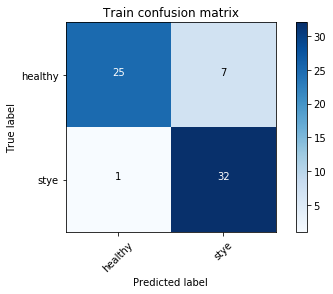

Confusion matrix, without normalization
[[8 2]
 [1 9]]


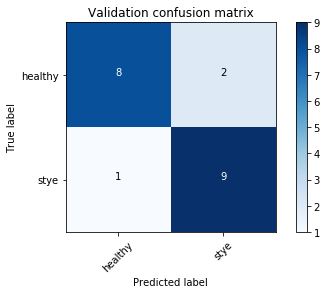

In [17]:
from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [18]:
# test image of healthy human eye
im=image.load_img('../eye_test_2class/test.jpg',target_size=([250,250]))

In [19]:
im=image.img_to_array(im)
im=im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))

In [20]:
im=preprocess_input(im)

In [21]:
ps=model.predict(im)

In [29]:
ps

array([[1., 0.]], dtype=float32)

In [23]:
import numpy as np

In [30]:
print (np.argmax(ps))

0


In [25]:
# test image of human eye with stye
im1=image.load_img('../eye_test_2class/test1.jpg',target_size=([250,250]))
im1=image.img_to_array(im1)
im1=im1.reshape((1, im1.shape[0], im1.shape[1], im1.shape[2]))

In [26]:
im1=preprocess_input(im1)
ps1=model.predict(im1)

In [28]:
ps1

array([[6.845464e-33, 1.000000e+00]], dtype=float32)

In [31]:
print (np.argmax(ps1))

1


In [34]:
from keras.models import model_from_json

In [35]:
# save the model to Json file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [36]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [37]:
ps=loaded_model.predict(im)

In [38]:
ps

array([[1., 0.]], dtype=float32)